In [1]:
# Load whole-brain TSNR data
import pandas as pd
import os

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

# Load the CSV file
try:
    data = pd.read_csv(csv_path)
    
    # Display the header (first 5 rows) and column names
    print("Column names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    
    # Display basic info about the data
    print("\nData info:")
    print(data.info())
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"Error loading file: {str(e)}")

Column names:
['Subject', 'ReceiveCoilName', 'AcquisitionType', 'tsnrMean', 'tsnrMedian']

First 5 rows of the data:
  Subject  ReceiveCoilName AcquisitionType   tsnrMean  tsnrMedian
0   10015               64          mb1me1  52.093262   47.814824
1   10015               64          mb3me1  57.683910   52.642603
2   10015               64          mb6me1  58.677708   53.953856
3   10017               64          mb1me1  39.583363   37.468284
4   10017               64          mb1me4  56.804039   51.711247

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subject          368 non-null    object 
 1   ReceiveCoilName  368 non-null    int64  
 2   AcquisitionType  368 non-null    object 
 3   tsnrMean         368 non-null    float64
 4   tsnrMedian       368 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory us

In [3]:
# Print statistics for whole-brain TSNR data
import pandas as pd
import os
from pymer4.models import Lmer
import numpy as np
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/code/combined_tsnr_coil_output.csv')

# Load the CSV file
try:
    data = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
    exit()
except Exception as e:
    print(f"Error loading file: {str(e)}")
    exit()

# Preprocess the data
data = data.rename(columns={
    'Subject': 'Subj',
    'ReceiveCoilName': 'HC',
    'tsnrMedian': 'TSNR'
})

# Extract MB and ME from AcquisitionType
data['MB'] = data['AcquisitionType'].str.extract(r'(mb\d+)')[0]
data['ME'] = data['AcquisitionType'].str.extract(r'(me\d+)')[0]

# Convert to categorical
data['HC'] = pd.Categorical(data['HC'], categories=[20, 64])
data['MB'] = pd.Categorical(data['MB'], categories=['mb1', 'mb3', 'mb6'])
data['ME'] = pd.Categorical(data['ME'], categories=['me1', 'me4'])
data['Subj'] = data['Subj'].astype(str)

# Filter out invalid rows and 'sp' subjects
data = data.dropna(subset=['TSNR', 'HC', 'MB', 'ME', 'Subj'])
data = data[~data['Subj'].str.contains('sp', na=False)]

# Print data summary
print("Data summary (unique subjects per condition):")
print(data.groupby(['HC', 'MB', 'ME'], observed=True)['Subj'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data.copy()
data_model['HC'] = data_model['HC'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['MB'] = pd.Categorical(data_model['MB'], categories=['mb1', 'mb3', 'mb6'])
data_model['ME'] = pd.Categorical(data_model['ME'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer('TSNR ~ HC * MB * ME + (1 | Subj)', data=data_model)
model.fit()

# Print model summary for debugging
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'HC': 'Head Coil',
    'MB': 'Multiband',
    'ME': 'Multi-echo',
    'HC:MB': 'Head Coil × Multiband',
    'HC:ME': 'Head Coil × Multi-echo',
    'MB:ME': 'Multiband × Multi-echo',
    'HC:MB:ME': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
# Extract residual variance from model.ranef_var
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    # Fallback: Use second row (index 1) for residual variance
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['Subj'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model (TSNR ~ HC * MB * ME + (1 | Subj)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_table.csv', index=False)

Data summary (unique subjects per condition):
HC  MB   ME 
20  mb1  me1    20
         me4    19
    mb3  me1    22
         me4    18
    mb6  me1    22
         me4    19
64  mb1  me1    26
         me4    25
    mb3  me1    25
         me4    25
    mb6  me1    25
         me4    25
Name: Subj, dtype: int64
Linear mixed model fit by REML [’lmerMod’]
Formula: TSNR~HC*MB*ME+(1|Subj)

Family: gaussian	 Inference: parametric

Number of observations: 271	 Groups: {'Subj': 48.0}

Log-likelihood: -719.516 	 AIC: 1467.032

Random effects:

                 Name     Var    Std
Subj      (Intercept)  19.945  4.466
Residual                8.161  2.857

No random effect correlations specified

Fixed effects:

pymer4.models.Lmer(fitted = True, formula = TSNR~HC*MB*ME+(1|Subj), family = gaussian)
SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)

ANOVA table:
                   SS        

In [5]:
# Load pre-smoothed data
import pandas as pd
import os

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv')

# Load the CSV file
try:
    data = pd.read_csv(csv_path)
    
    # Display the header (first 5 rows) and column names
    print("Column names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    
    # Display basic info about the data
    print("\nData info:")
    print(data.info())
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"Error loading file: {str(e)}")

Column names:
['sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-0mm.txt', 'acq', 'val', 'Unnamed: 3']

First 5 rows of the data:
  sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-0mm.txt  \
0                                           0.957374                                                                         
1  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
2                                           0.955262                                                                         
3  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
4                                           0.951923                                                                         

       acq      val  Unnamed: 3  
0  1.87266  16.

In [7]:
# Print stats for pre-smoothed data
import pandas as pd
import os
import re
import numpy as np
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all-zero.csv')

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "100 Seventy-eight", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Load and process the CSV file
try:
    data = pd.read_csv(csv_path)
    
    # Debug: Print raw data info
    print("\nRaw data info:")
    print(data.info())
    print("\nFirst 10 rows of raw data:")
    print(data.head(10))
    
    # Rename columns for clarity
    data = data.rename(columns={
        data.columns[0]: 'path',
        'Unnamed: 3': 'smoothness'
    })
    
    # Shift path column to align file paths with previous row's smoothness
    data['file_path'] = data['path'].shift(-1)
    
    # Filter rows with non-null smoothness
    data = data[data['smoothness'].notnull()]
    print(f"\nAfter filtering non-null smoothness: {len(data)} rows")
    
    # Debug: Print data with shifted paths
    print("\nData with shifted paths (first 5 rows):")
    print(data[['path', 'file_path', 'smoothness']].head())
    
    # Extract subject, mb, and me from file_path
    def parse_path(path):
        try:
            if not isinstance(path, str):
                return pd.Series({'subject': None, 'mb': None, 'me': None})
            sub_match = re.search(r'sub-(\d+)', path)
            acq_match = re.search(r'acq-(mb\dme\d)', path)
            subject = sub_match.group(1) if sub_match else None
            acq = acq_match.group(1) if acq_match else None
            if acq:
                mb = acq[:3]  # e.g., mb1
                me = acq[3:]  # e.g., me1
            else:
                mb = None
                me = None
            return pd.Series({'subject': subject, 'mb': mb, 'me': me})
        except Exception as e:
            print(f"Error parsing path {path}: {str(e)}")
            return pd.Series({'subject': None, 'mb': None, 'me': None})
    
    # Apply parsing to file_path
    parsed_data = data['file_path'].apply(parse_path)
    data = pd.concat([data, parsed_data], axis=1)
    
    # Debug: Print parsing results
    print(f"\nAfter parsing: {len(data)} rows")
    print("\nParsed data (first 5 rows):")
    print(data[['file_path', 'subject', 'mb', 'me', 'smoothness']].head())
    
    # Assign headcoil
    data['headcoil'] = data['subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20' if x else None)
    
    # Select relevant columns
    data = data[['subject', 'headcoil', 'mb', 'me', 'smoothness']]
    
    # Convert to categorical
    data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
    data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
    data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
    data['subject'] = data['subject'].astype(str)
    
    # Filter out invalid rows
    data = data.dropna(subset=['subject', 'mb', 'me', 'smoothness'])
    data = data[~data['subject'].str.contains('sp', na=False)]
    data = data[data['subject'] != 'nan']
    
    # Debug: Print final data
    print(f"\nProcessed {len(data)} rows with {data['subject'].nunique()} unique subjects")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Check if data is empty
if data.empty:
    print("Error: No valid data after processing. Please check file paths and parsing logic.")
    print("\nDebug: Raw data sample (first 10 rows):")
    raw_data = pd.read_csv(csv_path)
    print(raw_data.head(10))
    exit()

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer('smoothness ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model (smoothness ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('pre-smoothness_lme_anova.csv', index=False)
print("\n")


Raw data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 4 columns):
 #   Column                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                    --------------  -----  
 0   sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-0mm.txt  679 non-null    object 
 1   acq                                                                                                                       340 non-null    float64
 2   val                                                                                                                       340 non-null    float64
 3   Unnamed: 3                                                                                                              

In [9]:
# Load post-smoothed data
import pandas as pd
import os

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Load the CSV file
try:
    data = pd.read_csv(csv_path)
    
    # Display the header (first 5 rows) and column names
    print("Column names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    
    # Display basic info about the data
    print("\nData info:")
    print(data.info())
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
except Exception as e:
    print(f"Error loading file: {str(e)}")

Column names:
['sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-5mm.txt', 'acq', 'val', 'Unnamed: 3']

First 5 rows of the data:
  sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-5mm.txt  \
0                                           0.959011                                                                         
1  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
2                                           0.952358                                                                         
3  sub-10015/L1_task-sharedreward_model-1_type-ac...                                                                         
4                                           0.946439                                                                         

       acq      val  Unnamed: 3  
0  1.99700  18.

In [11]:
# Print stats for post-smoothed data
import pandas as pd
import os
import re
import numpy as np
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "100 Seventy-eight", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Load and process the CSV file
try:
    data = pd.read_csv(csv_path)
    
    # Debug: Print raw data info
    print("\nRaw data info:")
    print(data.info())
    print("\nFirst 10 rows of raw data:")
    print(data.head(10))
    
    # Rename columns for clarity
    data = data.rename(columns={
        data.columns[0]: 'path',
        'Unnamed: 3': 'smoothness'
    })
    
    # Shift path column to align file paths with previous row's smoothness
    data['file_path'] = data['path'].shift(-1)
    
    # Filter rows with non-null smoothness
    data = data[data['smoothness'].notnull()]
    print(f"\nAfter filtering non-null smoothness: {len(data)} rows")
    
    # Debug: Print data with shifted paths
    print("\nData with shifted paths (first 5 rows):")
    print(data[['path', 'file_path', 'smoothness']].head())
    
    # Extract subject, mb, and me from file_path
    def parse_path(path):
        try:
            if not isinstance(path, str):
                return pd.Series({'subject': None, 'mb': None, 'me': None})
            sub_match = re.search(r'sub-(\d+)', path)
            acq_match = re.search(r'acq-(mb\dme\d)', path)
            subject = sub_match.group(1) if sub_match else None
            acq = acq_match.group(1) if acq_match else None
            if acq:
                mb = acq[:3]  # e.g., mb1
                me = acq[3:]  # e.g., me1
            else:
                mb = None
                me = None
            return pd.Series({'subject': subject, 'mb': mb, 'me': me})
        except Exception as e:
            print(f"Error parsing path {path}: {str(e)}")
            return pd.Series({'subject': None, 'mb': None, 'me': None})
    
    # Apply parsing to file_path
    parsed_data = data['file_path'].apply(parse_path)
    data = pd.concat([data, parsed_data], axis=1)
    
    # Debug: Print parsing results
    print(f"\nAfter parsing: {len(data)} rows")
    print("\nParsed data (first 5 rows):")
    print(data[['file_path', 'subject', 'mb', 'me', 'smoothness']].head())
    
    # Assign headcoil
    data['headcoil'] = data['subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20' if x else None)
    
    # Select relevant columns
    data = data[['subject', 'headcoil', 'mb', 'me', 'smoothness']]
    
    # Convert to categorical
    data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
    data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
    data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
    data['subject'] = data['subject'].astype(str)
    
    # Filter out invalid rows
    data = data.dropna(subset=['subject', 'mb', 'me', 'smoothness'])
    data = data[~data['subject'].str.contains('sp', na=False)]
    data = data[data['subject'] != 'nan']
    
    # Debug: Print final data
    print(f"\nProcessed {len(data)} rows with {data['subject'].nunique()} unique subjects")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Check if data is empty
if data.empty:
    print("Error: No valid data after processing. Please check file paths and parsing logic.")
    print("\nDebug: Raw data sample (first 10 rows):")
    raw_data = pd.read_csv(csv_path)
    print(raw_data.head(10))
    exit()

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer('smoothness ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model (smoothness ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('post-smoothness_lme_anova.csv', index=False)
print("\n")


Raw data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 4 columns):
 #   Column                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                    --------------  -----  
 0   sub-10015/L1_task-sharedreward_model-1_type-act_acq-mb1me1_sm-5_denoising-base_EstimateSmoothing.feat/smoothness-5mm.txt  679 non-null    object 
 1   acq                                                                                                                       340 non-null    float64
 2   val                                                                                                                       340 non-null    float64
 3   Unnamed: 3                                                                                                              

In [13]:
# Load ROI-based data
import os
import re
import pandas as pd
import numpy as np
import glob

# Define parameters
TYPE_VALUE = "act"  # Filter for type-act
IMG_VALUE = "tsnr"  # Filter for img-tsnr
MASK_VALUE = "VSconstrained"  # Single mask for this example
DENOISE_VALUE = "base"  # Filter for denoise-base
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
except Exception as e:
    print(f"Error processing data: {str(e)}")


Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
15    10017       64  47.441217  48.736170  43.101251  70.091718  58.504754   
16    10024       64  41.595123  53.181006  51.031723  64.281742  60.599686   
7     10035       64  51.308512  46.870595  38.905418  72.807299  63.647671   
22    10041       64  44.525315  38.940282  39.330609  51.993155  45.745058   
0     10043       64  56.283196  52.007653  51.011447  59.484562  54.419625   

       mb6me4  
15  42.642998  
16  45.972115  
7   46.401998  
22  43.801459  
0   41.067986  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 15 to 26
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null 

In [15]:
# Print stats for TSNR in VS
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "tsnr"
MASK_VALUE = "VSconstrained"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=act, img=tsnr, mask=VSconstrained, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
15    10017       64  47.441217  48.736170  43.101251  70.091718  58.504754   
16    10024       64  41.595123  53.181006  51.031723  64.281742  60.599686   
7     10035       64  51.308512  46.870595  38.905418  72.807299  63.647671   
22    10041       64  44.525315  38.940282  39.330609  51.993155  45.745058   
0     10043       64  56.283196  52.007653  51.011447  59.484562  54.419625   

       mb6me4  
15  42.642998  
16  45.972115  
7   46.401998  
22  43.801459  
0   41.067986  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 15 to 26
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null 

In [17]:
# Print stats for TSNR in rFFA
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "tsnr"
MASK_VALUE = "rFFA"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=act, img=tsnr, mask=rFFA, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil     mb1me1     mb3me1     mb6me1     mb1me4     mb3me4  \
5     10017       64  69.647290  71.641840  73.404557  87.405826  73.873885   
14    10024       64  63.938418  76.911694  77.598268  79.015024  86.548588   
21    10035       64  73.213793  66.518095  56.318987  82.720226  81.743406   
27    10041       64  49.504132  49.945471  37.367659  53.528671  50.536741   
39    10043       64  71.905630  62.830008  69.158210  76.025266  64.627206   

       mb6me4  
5   71.031138  
14  80.991121  
21  59.304167  
27  62.119361  
39  54.548213  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 5 to 20
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null     int64 

In [19]:
# Print stats for TSNR in Motor Cortex
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "tsnr"
MASK_VALUE = "bilateralMotor"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=act, img=tsnr, mask=bilateralMotor, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil   mb1me1   mb3me1   mb6me1   mb1me4   mb3me4   mb6me4
16    10017       64  72.6323  72.7564  70.1925  88.8262  78.1367  71.2849
3     10024       64  66.2912  74.3443  86.8906  68.7106  89.1001  81.3267
32    10035       64  79.2721  70.5289  66.5504  73.7720  75.7880  67.1326
14    10041       64  61.2038  51.3882  47.4777  36.7768  47.5231  69.5641
11    10043       64  81.4146  72.9499  83.3386  84.4824  70.1703  66.0164

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 16 to 19
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null     int64  
 1   headcoil  40 non-null     object 
 2   mb1me1    40 non-null     float64
 3   mb3me1    40 non-null    

In [21]:
# Print stats for Beta Activation in VS
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "beta"
MASK_VALUE = "VSconstrained"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
15    10017       64   -4.671750   94.225272 -104.142611 -162.286756   
14    10024       64  108.144702  171.678553  -71.579402  194.614259   
6     10035       64  177.945209   31.420981  -54.147004  346.247572   
38    10041       64  -49.422607  139.081973   60.893990  199.377341   
35    10043       64   40.083598  171.309089  261.922597  522.679206   

        mb3me4      mb6me4  
15   99.403756  -85.024436  
14  373.619278  223.327079  
6  -154.840010   11.494569  
38   85.674422  407.643753  
35  311.496890  234.641249  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 15 to 26
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    -------------- 

In [23]:
# Print stats for Beta Activation in rFFA
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "beta"
MASK_VALUE = "rFFA"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=act, img=beta, mask=rFFA, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil      mb1me1      mb3me1      mb6me1      mb1me4  \
18    10017       64  108.383949  -28.227425 -117.096297   17.259745   
2     10024       64  213.845285  154.215540  134.060013  221.536303   
32    10035       64  -74.840209   24.337354 -118.085449    8.767847   
37    10041       64    8.856368   20.112287   85.819809  155.011321   
26    10043       64   51.022825   69.229564   -1.123204   55.814447   

        mb3me4      mb6me4  
18  112.514954   65.610080  
2    80.394438   92.839670  
32   94.273438   37.190282  
37   59.496051  176.974169  
26  137.657878  112.265923  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 18 to 7
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 

In [25]:
# Print stats for Beta Activation in Motor Cortex
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "beta"
MASK_VALUE = "bilateralMotor"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=act, img=beta, mask=bilateralMotor, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil    mb1me1   mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017       64  60.34220 -23.8654 -88.55070  -73.6003   25.7673   
4     10024       64   3.34565  11.7991  35.37590   68.2037   86.5219   
35    10035       64 -72.56520 -30.2285  67.68060   47.2171   17.5470   
19    10041       64  85.98050  89.9091  -3.28938   78.8632  116.1790   
3     10043       64  77.28440  85.4412  89.75140  120.4870   79.5741   

       mb6me4  
17    7.49806  
4   104.16500  
35   52.49900  
19   82.03830  
3    97.71920  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 17 to 13
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null     int64  
 1   headcoil  40 non-n

In [27]:
# Print stats for PPI in MEbonf
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "ppi_seed-VS_thr5"
IMG_VALUE = "beta"
MASK_VALUE = "MEbonf"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=MEbonf, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
15    10017       64  0.486777  0.388941  0.170893  0.839128  0.613383   
12    10024       64  0.094442  0.222161  0.350732  0.119211 -0.029392   
25    10035       64  0.015217  0.288969  0.156517  0.441444  0.101959   
20    10041       64 -0.165057  0.259974  0.281639  0.798387 -0.223576   
34    10043       64 -0.357800 -0.039439  0.198245  1.034978  0.493550   

      mb6me4  
15  0.400882  
12  0.418424  
25 -0.001471  
20  0.229793  
34  0.293688  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 15 to 39
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null     int64  
 1   headcoil  40 

In [29]:
# Print stats for PPI in HCxMEbonf
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "ppi_seed-VS_thr5"
IMG_VALUE = "beta"
MASK_VALUE = "HCxMEbonf"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=HCxMEbonf, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017       64  0.203739  0.082983  0.215631  0.423486  0.381277   
22    10024       64  0.579353  0.435715  0.385691  0.553665  0.416106   
25    10035       64  0.418350 -0.018536  0.358205  0.227374 -0.025990   
36    10041       64 -0.389665 -0.061145  0.267286  0.236136  0.293913   
1     10043       64 -0.381371 -0.062987  0.287128  0.877632  0.281280   

      mb6me4  
17  0.206153  
22  0.451838  
25  0.008355  
36  0.071903  
1   0.322555  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 17 to 8
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null     int64  
 1   headcoil  4

In [31]:
# Print stats for PPI in 3waybonf
import os
import re
import pandas as pd
import numpy as np
import glob
from pymer4.models import Lmer
import warnings

# Suppress FutureWarning from pymer4 about DataFrame.applymap
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)

# Define parameters
TYPE_VALUE = "ppi_seed-VS_thr5"
IMG_VALUE = "beta"
MASK_VALUE = "3waybonf"
DENOISE_VALUE = "base"
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")

# Define subjects with 64-channel headcoil
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

def extract_file_data(base_dir, type_value, img_value, mask_value, denoise_value):
    """Extract data from files matching the given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_by_subject = {}
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id:
                continue
            if (file_type == type_value and img == img_value 
                and mask == mask_value and denoise == denoise_value):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    return data_by_subject

def create_dataframe(data_by_subject, headcoil_64_subjects):
    """Create a DataFrame from the collected data"""
    acq_params = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    try:
        df = pd.DataFrame.from_dict(data_by_subject, orient='index')
        if df.empty:
            raise ValueError("No data extracted from files")
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'subject'}, inplace=True)
        df['headcoil'] = df['subject'].apply(lambda x: '64' if x in headcoil_64_subjects else '20')
        column_order = ['subject', 'headcoil'] + acq_params
        df = df[column_order]
        df['subject'] = df['subject'].astype(int)
        df.sort_values('subject', inplace=True)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {str(e)}")
        return None

# Extract and create DataFrame
try:
    print(f"\nProcessing files with parameters: type={TYPE_VALUE}, img={IMG_VALUE}, mask={MASK_VALUE}, denoise={DENOISE_VALUE}")
    data_by_subject = extract_file_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE)
    if not data_by_subject:
        raise FileNotFoundError(f"No matching files found in {BASE_DIR} for specified parameters")
    
    data = create_dataframe(data_by_subject, HEADCOIL_64_SUBJECTS)
    if data is None:
        raise ValueError("Failed to create DataFrame")
    
    # Display basic information
    print("\nColumn names:")
    print(data.columns.tolist())
    print("\nFirst 5 rows of the data:")
    print(data.head())
    print("\nData info:")
    print(data.info())
    
except FileNotFoundError as e:
    print(f"Error: {str(e)}")
    exit()
except Exception as e:
    print(f"Error processing data: {str(e)}")
    exit()

# Reshape to long format for mixed effects model
data_long = pd.melt(
    data,
    id_vars=['subject', 'headcoil'],
    value_vars=['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4'],
    var_name='acq',
    value_name=IMG_VALUE
)
data_long['mb'] = data_long['acq'].str[:3]
data_long['me'] = data_long['acq'].str[3:]
data_long = data_long.drop(columns=['acq'])

# Convert to categorical
data_long['headcoil'] = pd.Categorical(data_long['headcoil'], categories=['20', '64'])
data_long['mb'] = pd.Categorical(data_long['mb'], categories=['mb1', 'mb3', 'mb6'])
data_long['me'] = pd.Categorical(data_long['me'], categories=['me1', 'me4'])
data_long['subject'] = data_long['subject'].astype(str)

# Filter out rows with missing tsnr
data_long = data_long.dropna(subset=[IMG_VALUE])

# Print data summary
print("\nData summary (unique subjects per condition):")
print(data_long.groupby(['headcoil', 'mb', 'me'], observed=True)['subject'].nunique())

# Prepare data for pymer4 with sum-to-zero contrasts
data_model = data_long.copy()
data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
data_model['mb'] = pd.Categorical(data_model['mb'], categories=['mb1', 'mb3', 'mb6'])
data_model['me'] = pd.Categorical(data_model['me'], categories=['me1', 'me4'])

# Fit the LME model with pymer4
model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + (1 | subject)', data=data_model)
model.fit()

# Print model summary
print(model)

# Get ANOVA table with Satterthwaite approximation
anova_table = model.anova()
print("\nANOVA table:")
print(anova_table)

# Define effect names and numerator df
effect_map = {
    'headcoil': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'headcoil:mb': 'Head Coil × Multiband',
    'headcoil:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
}
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA table
apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan  # Computed below
    })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError) as e:
    print("Error accessing residual variance, printing model.ranef_var for debugging:")
    print(model.ranef_var)
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(data_model)
n_fixed = sum(df_dict.values())
n_subj = data_model['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Print and save APA table
print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv('tsnr_lme_anova_VSconstrained.csv', index=False)


Processing files with parameters: type=ppi_seed-VS_thr5, img=beta, mask=3waybonf, denoise=base

Column names:
['subject', 'headcoil', 'mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

First 5 rows of the data:
    subject headcoil    mb1me1    mb3me1    mb6me1    mb1me4    mb3me4  \
17    10017       64  0.684160 -0.128641  0.312095  0.475833  0.900211   
11    10024       64  0.382074 -0.018033  0.291868 -1.074285 -0.646402   
33    10035       64  1.911335  0.642379  1.156153 -0.071363 -0.471017   
35    10041       64 -1.024630 -0.028349  0.084596  0.757710  0.611920   
6     10043       64 -0.514169  0.339286  0.713070  2.427103  0.808691   

      mb6me4  
17  0.347780  
11  0.311822  
33  0.159031  
35 -0.257437  
6   0.686846  

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 17 to 4
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   subject   40 non-null     int64  
 1   headcoil  40

In [33]:
# Figure 8 Part 1, Generate avg fd_mean values for each ME acq
import pandas as pd

# Define file paths
input_file = "~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv"
output_file = "~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv"

# Load the TSV file
df = pd.read_csv(input_file, sep="\t")

# Filter out subjects ending in 'sp' and acquisitions containing 'me1'
df = df[~df['Sub'].str.endswith('sp')]
df = df[~df['acq'].str.contains('me1', na=False)]

# Save the filtered DataFrame to a CSV file
df.to_csv(output_file, index=False)

#print("Filtered data saved to:", output_file)

import pandas as pd

# Load your spreadsheet data
df = pd.read_csv(output_file)

# Extract the base 'acq' substring (e.g., mb1me4, mb3me4, mb6me4) from the 'acq' column
df['acq_base'] = df['acq'].str.extract(r'(mb\dme4)')

# Group by 'Sub' and 'acq_base' and calculate the average of 'fd_mean' for each group
averages = df.groupby(['Sub', 'acq_base'])['fd_mean'].mean().reset_index()

# Save the results to a new spreadsheet
output_file_path = 'fd_mean_averages.xlsx'  # Replace with your desired output file path
averages.to_excel(output_file_path, index=False)

# Optionally, print the averages to verify
print(averages)

          Sub acq_base   fd_mean
0   sub-10017   mb1me4  0.065809
1   sub-10017   mb3me4  0.093968
2   sub-10017   mb6me4  0.087372
3   sub-10028   mb1me4  0.043817
4   sub-10028   mb3me4  0.082697
..        ...      ...       ...
86  sub-10716   mb3me4  0.579043
87  sub-10738   mb1me4  0.326083
88  sub-12042   mb1me4  0.091052
89  sub-12042   mb3me4  0.103584
90  sub-12042   mb6me4  0.100240

[91 rows x 3 columns]



Processing files for tedana - base difference: type=act, img=zstat, mask=VSconstrained
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_zstat_VSconstrained.csv
Found data for 40 subjects

Sample of the merged data:
  subject     acq  tedana_minus_base   fd_mean
0   10017  mb1me4          -0.006158  0.065809
1   10017  mb1me4          -0.006158  0.065809
2   10017  mb1me4          -0.006158  0.065809
3   10017  mb1me4          -0.006158  0.065809
4   10024  mb1me4           0.071574       NaN

Generating summary statistics table...
Summary table saved to summary_stats_act_zstat_VSconstrained.csv

APA-style Summary Table:
Acquisition   N    Mean (SD)         Range  Pearson r (95% CI) p-value     Slope (p) R-squared
     mb1me4 100 -0.01 (0.11) [-0.36, 0.17]  0.01 [-0.19, 0.21]   1.000  0.02 (0.911)      0.0

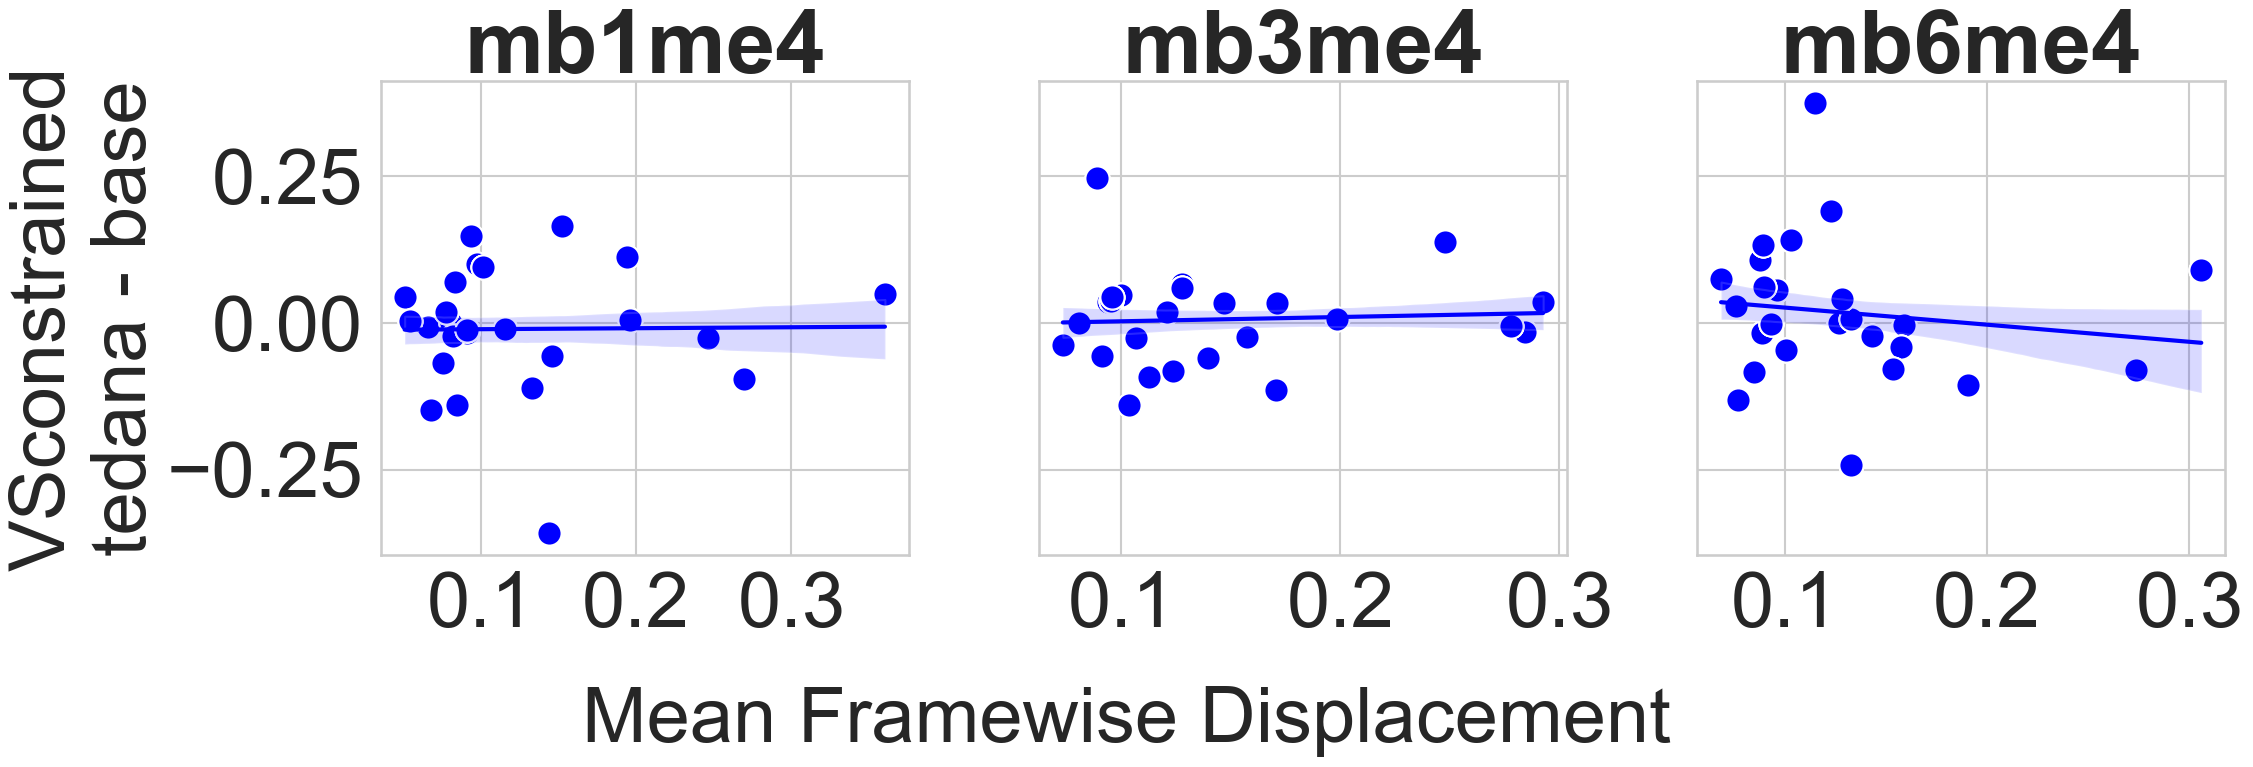

In [53]:
# Print base - tedana stats for VS
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    column_order = ['subject'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def generate_summary_table(df, acq_params):
    """Generate APA-style summary table of statistics for each acquisition"""
    stats_data = {
        'Acquisition': [],
        'N': [],
        'Mean (SD)': [],
        'Range': [],
        'Pearson r (95% CI)': [],
        'p-value': [],
        'Slope (p)': [],
        'R-squared': []
    }
    
    # Bonferroni correction for 3 acquisitions
    alpha = 0.05 / len(acq_params)
    
    for acq in acq_params:
        acq_data = df[df['acq'] == acq].dropna(subset=['fd_mean', 'tedana_minus_base'])
        
        # Sample size
        n = len(acq_data)
        
        # Descriptive statistics
        mean = acq_data['tedana_minus_base'].mean()
        sd = acq_data['tedana_minus_base'].std()
        min_val = acq_data['tedana_minus_base'].min()
        max_val = acq_data['tedana_minus_base'].max()
        
        # Correlation
        if n > 1:
            r, p = stats.pearsonr(acq_data['fd_mean'], acq_data['tedana_minus_base'])
            # 95% CI for Pearson's r
            z = np.arctanh(r)
            se = 1 / np.sqrt(n - 3)
            ci_lower_z = z - 1.96 * se
            ci_upper_z = z + 1.96 * se
            ci_lower = np.tanh(ci_lower_z)
            ci_upper = np.tanh(ci_upper_z)
            ci = f"[{ci_lower:.2f}, {ci_upper:.2f}]"
            p_corrected = min(p * len(acq_params), 1.0)  # Bonferroni correction
        else:
            r, p, ci, p_corrected = np.nan, np.nan, "[N/A, N/A]", np.nan
        
        # Regression
        if n > 1:
            slope, intercept, r_value, p_slope, _ = stats.linregress(acq_data['fd_mean'], acq_data['tedana_minus_base'])
            r_squared = r_value ** 2
        else:
            slope, p_slope, r_squared = np.nan, np.nan, np.nan
        
        # Format statistics
        stats_data['Acquisition'].append(acq)
        stats_data['N'].append(n)
        stats_data['Mean (SD)'].append(f"{mean:.2f} ({sd:.2f})")
        stats_data['Range'].append(f"[{min_val:.2f}, {max_val:.2f}]")
        stats_data['Pearson r (95% CI)'].append(f"{r:.2f} {ci}")
        stats_data['p-value'].append(f"{p_corrected:.3f}" if not np.isnan(p_corrected) else "N/A")
        stats_data['Slope (p)'].append(f"{slope:.2f} ({p_slope:.3f})" if not np.isnan(slope) else "N/A")
        stats_data['R-squared'].append(f"{r_squared:.2f}" if not np.isnan(r_squared) else "N/A")
    
    summary_df = pd.DataFrame(stats_data)
    return summary_df

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create scatter plots without headcoil split (blue dots)"""
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)
    
    for i, acq in enumerate(acq_params):
        ax = axes[i] if len(acq_params) > 1 else axes
        acq_data = df[df['acq'] == acq]
        
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax, s=300
        )
        
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax, color='blue', line_kws={'linewidth': 3})
        
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=56)
        ax.set_xlabel('')
    
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)
    plt.tight_layout()
    
    return fig

def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the analysis for tedana-base difference visualization (no headcoil split)"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    # Generate summary table
    print("\nGenerating summary statistics table...")
    summary_table = generate_summary_table(df, acq_params)
    if save_files:
        table_file = f"summary_stats_{type_value}_{img_value}_{mask_value}.csv"
        summary_table.to_csv(table_file, index=False)
        print(f"Summary table saved to {table_file}")
    print("\nAPA-style Summary Table:")
    print(summary_table.to_string(index=False))
    
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig,
        'summary_table': summary_table
    }

if __name__ == "__main__":
    TYPE_VALUE = "act"
    IMG_VALUE = "zstat"
    MASK_VALUE = "VSconstrained"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=beta, mask=rFFA
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_beta_rFFA.csv
Found data for 40 subjects

Sample of the merged data:
  subject     acq  tedana_minus_base   fd_mean
0   10017  mb1me4          40.377209  0.065809
1   10017  mb1me4          40.377209  0.065809
2   10017  mb1me4          40.377209  0.065809
3   10017  mb1me4          40.377209  0.065809
4   10024  mb1me4          26.206327       NaN

Generating summary statistics table...
Summary table saved to summary_stats_act_beta_rFFA.csv

APA-style Summary Table:
Acquisition   N     Mean (SD)            Range  Pearson r (95% CI) p-value      Slope (p) R-squared
     mb1me4 100 31.86 (59.80) [-77.92, 160.26] -0.11 [-0.30, 0.09]   0.876 -85.86 (0.292)      0.01
     mb3me4 100 21

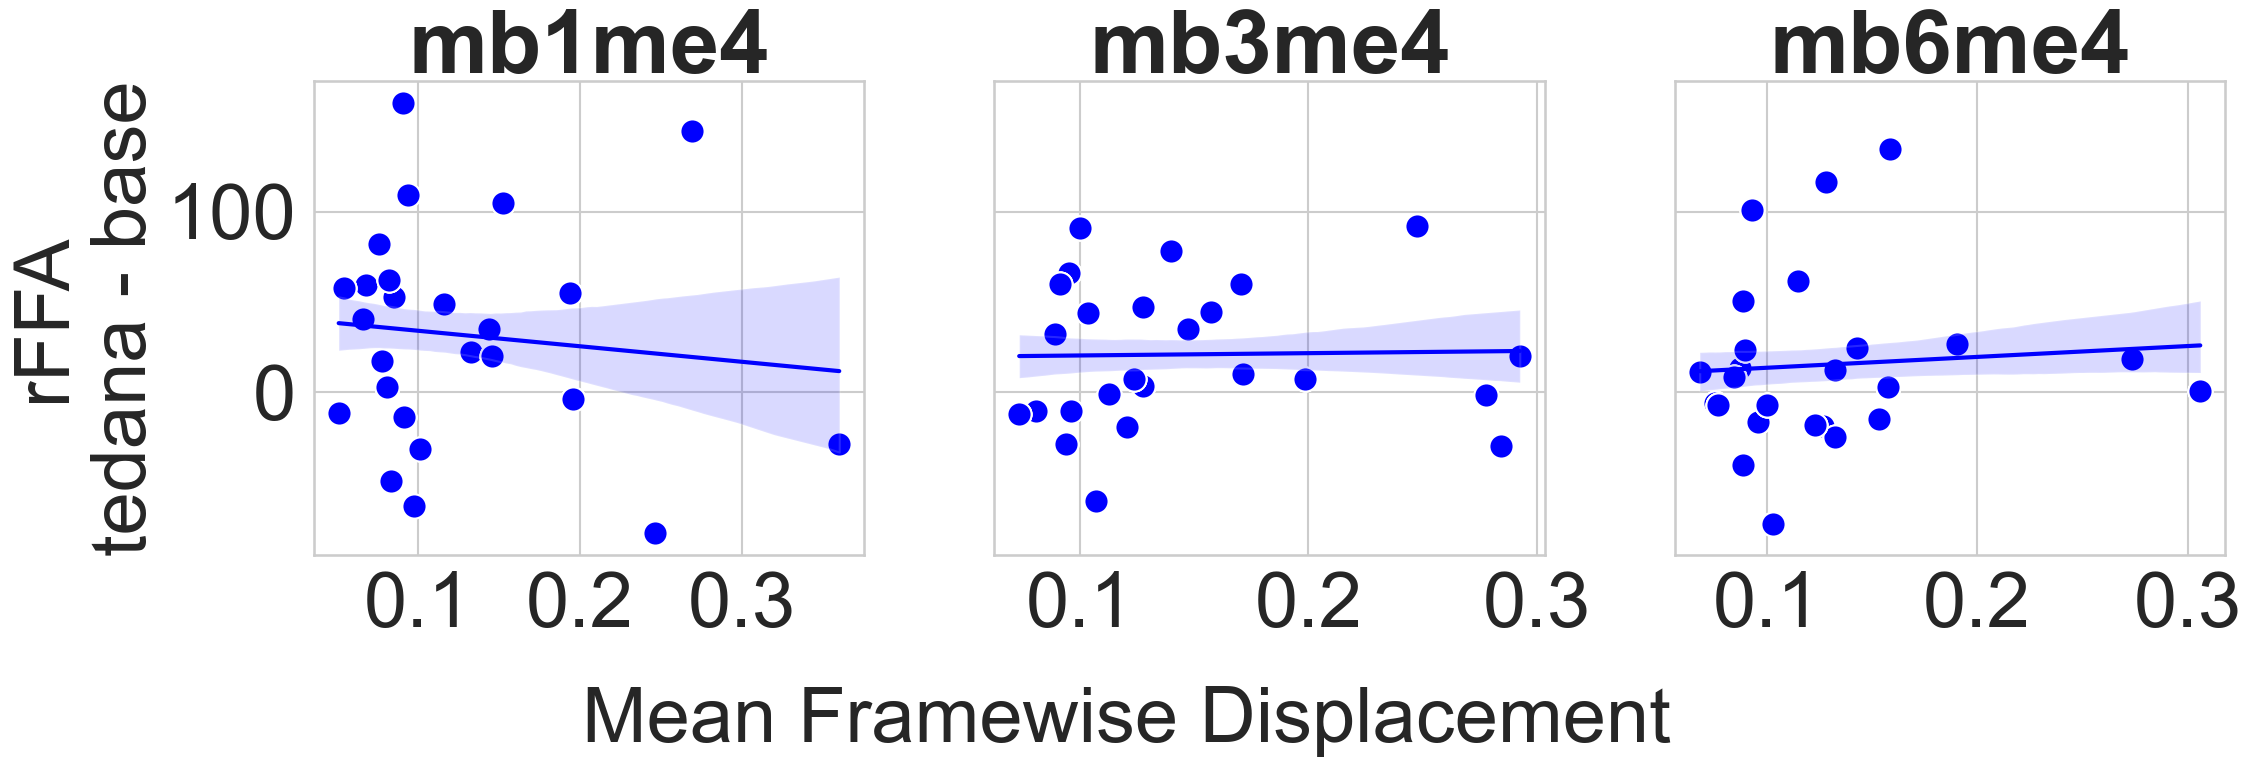

In [36]:
# Print base - tedana stats for rFFA
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    column_order = ['subject'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def generate_summary_table(df, acq_params):
    """Generate APA-style summary table of statistics for each acquisition"""
    stats_data = {
        'Acquisition': [],
        'N': [],
        'Mean (SD)': [],
        'Range': [],
        'Pearson r (95% CI)': [],
        'p-value': [],
        'Slope (p)': [],
        'R-squared': []
    }
    
    # Bonferroni correction for 3 acquisitions
    alpha = 0.05 / len(acq_params)
    
    for acq in acq_params:
        acq_data = df[df['acq'] == acq].dropna(subset=['fd_mean', 'tedana_minus_base'])
        
        # Sample size
        n = len(acq_data)
        
        # Descriptive statistics
        mean = acq_data['tedana_minus_base'].mean()
        sd = acq_data['tedana_minus_base'].std()
        min_val = acq_data['tedana_minus_base'].min()
        max_val = acq_data['tedana_minus_base'].max()
        
        # Correlation
        if n > 1:
            r, p = stats.pearsonr(acq_data['fd_mean'], acq_data['tedana_minus_base'])
            # 95% CI for Pearson's r
            z = np.arctanh(r)
            se = 1 / np.sqrt(n - 3)
            ci_lower_z = z - 1.96 * se
            ci_upper_z = z + 1.96 * se
            ci_lower = np.tanh(ci_lower_z)
            ci_upper = np.tanh(ci_upper_z)
            ci = f"[{ci_lower:.2f}, {ci_upper:.2f}]"
            p_corrected = min(p * len(acq_params), 1.0)  # Bonferroni correction
        else:
            r, p, ci, p_corrected = np.nan, np.nan, "[N/A, N/A]", np.nan
        
        # Regression
        if n > 1:
            slope, intercept, r_value, p_slope, _ = stats.linregress(acq_data['fd_mean'], acq_data['tedana_minus_base'])
            r_squared = r_value ** 2
        else:
            slope, p_slope, r_squared = np.nan, np.nan, np.nan
        
        # Format statistics
        stats_data['Acquisition'].append(acq)
        stats_data['N'].append(n)
        stats_data['Mean (SD)'].append(f"{mean:.2f} ({sd:.2f})")
        stats_data['Range'].append(f"[{min_val:.2f}, {max_val:.2f}]")
        stats_data['Pearson r (95% CI)'].append(f"{r:.2f} {ci}")
        stats_data['p-value'].append(f"{p_corrected:.3f}" if not np.isnan(p_corrected) else "N/A")
        stats_data['Slope (p)'].append(f"{slope:.2f} ({p_slope:.3f})" if not np.isnan(slope) else "N/A")
        stats_data['R-squared'].append(f"{r_squared:.2f}" if not np.isnan(r_squared) else "N/A")
    
    summary_df = pd.DataFrame(stats_data)
    return summary_df

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create scatter plots without headcoil split (blue dots)"""
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)
    
    for i, acq in enumerate(acq_params):
        ax = axes[i] if len(acq_params) > 1 else axes
        acq_data = df[df['acq'] == acq]
        
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax, s=300
        )
        
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax, color='blue', line_kws={'linewidth': 3})
        
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=56)
        ax.set_xlabel('')
    
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)
    plt.tight_layout()
    
    return fig

def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the analysis for tedana-base difference visualization (no headcoil split)"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    # Generate summary table
    print("\nGenerating summary statistics table...")
    summary_table = generate_summary_table(df, acq_params)
    if save_files:
        table_file = f"summary_stats_{type_value}_{img_value}_{mask_value}.csv"
        summary_table.to_csv(table_file, index=False)
        print(f"Summary table saved to {table_file}")
    print("\nAPA-style Summary Table:")
    print(summary_table.to_string(index=False))
    
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig,
        'summary_table': summary_table
    }

if __name__ == "__main__":
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "rFFA"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )


Processing files for tedana - base difference: type=act, img=beta, mask=bilateralMotor
Found 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Subjects with data: 40

Number of NaN fd_mean values after merge: 45 out of 345 rows
Data saved to multiecho_tedana_minus_base_act_beta_bilateralMotor.csv
Found data for 40 subjects

Sample of the merged data:
  subject     acq  tedana_minus_base   fd_mean
0   10017  mb1me4           146.3451  0.065809
1   10017  mb1me4           146.3451  0.065809
2   10017  mb1me4           146.3451  0.065809
3   10017  mb1me4           146.3451  0.065809
4   10024  mb1me4           -29.1127       NaN

Generating summary statistics table...
Summary table saved to summary_stats_act_beta_bilateralMotor.csv

APA-style Summary Table:
Acquisition   N     Mean (SD)            Range   Pearson r (95% CI) p-value       Slope (p) R-squared
     mb1me4  92 17.95 (43.89) [-36.33, 146.35]   0.02 [-0.18, 0.23]   1.000   12.42 (0

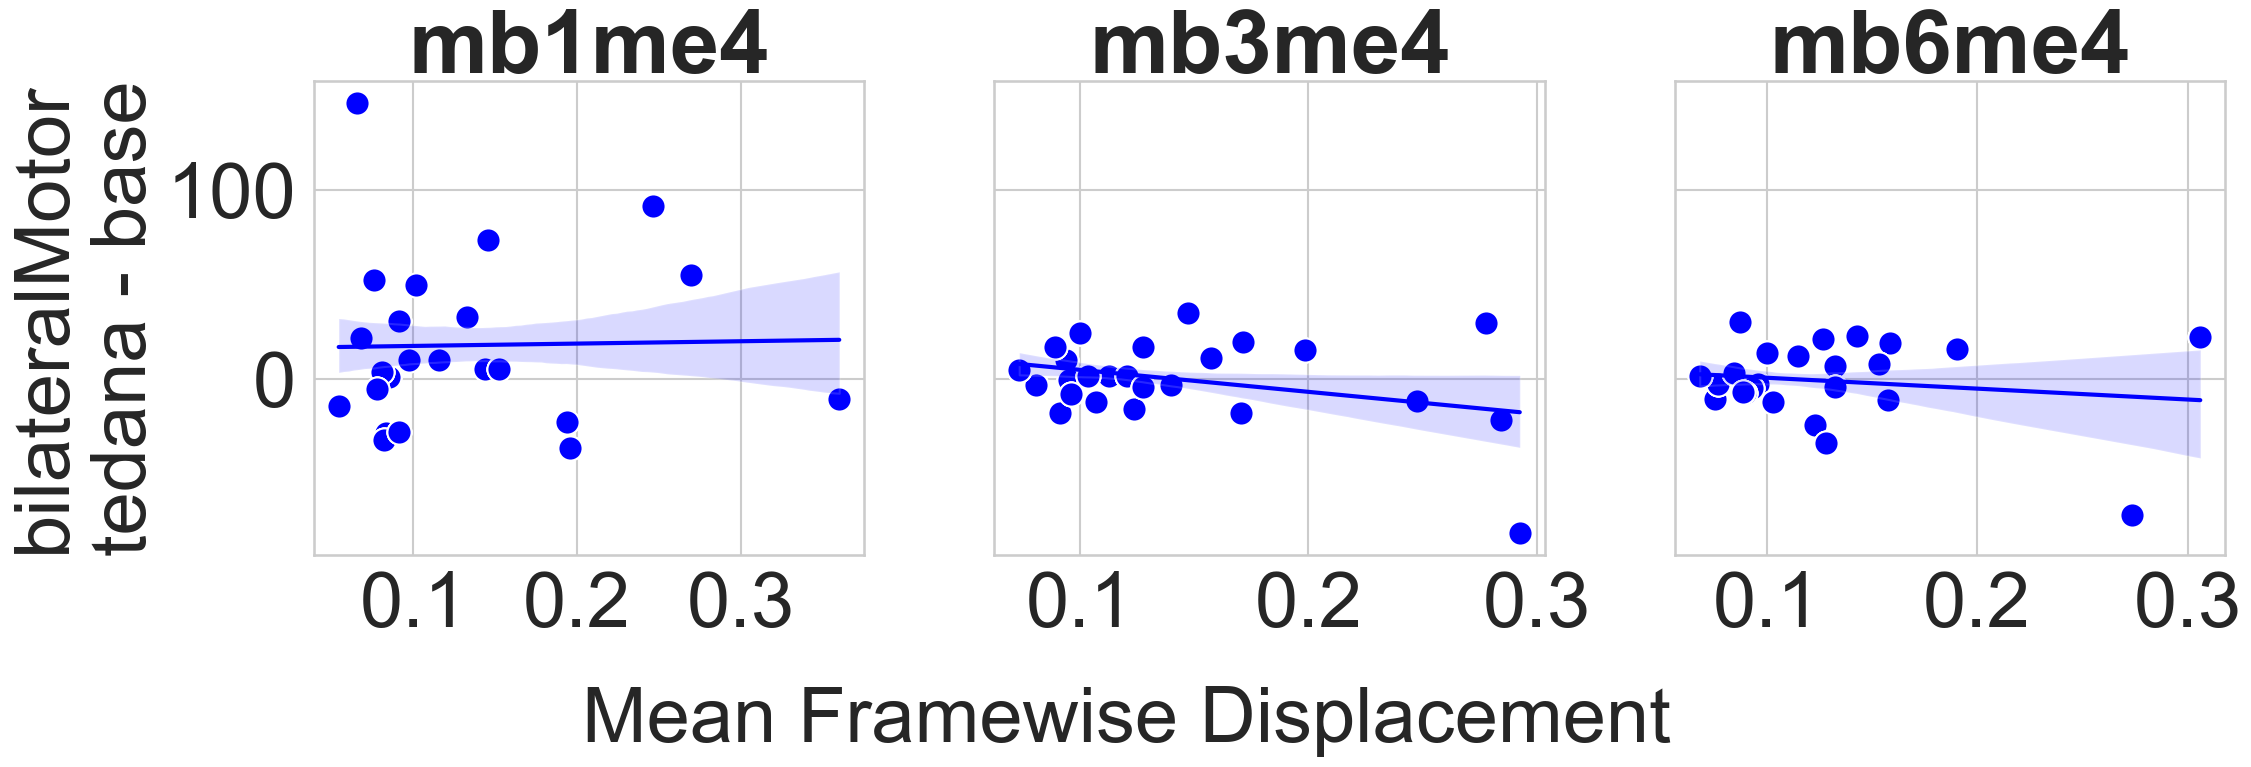

In [38]:
# Print base - tedana stats for Motor Cortex
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

def initialize_plotting_engine():
    """Initialize the plotting environment with required settings"""
    sns.set_style("whitegrid")
    sns.set_context("talk")
    plt.rcParams.update({'font.size': 56})

def extract_file_data_with_difference(base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params):
    """Extract data and calculate differences between denoise methods for given parameters"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    
    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    print(f"Found {len(file_paths)} files in {base_dir}")
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or acq not in acq_params:
                continue
            if (file_type == type_value and img == img_value and mask == mask_value and 
                denoise in [denoise_tedana, denoise_base]):
                try:
                    with open(file_path, 'r') as f:
                        raw_content = f.read().strip()
                        value = float(raw_content)
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {
                            denoise: {acq_param: np.nan for acq_param in acq_params}
                            for denoise in [denoise_tedana, denoise_base]
                        }
                    data_by_subject[sub_id][denoise][acq] = value
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")
    
    print(f"Subjects with data: {len(data_by_subject)}")
    
    diff_by_subject = {}
    for sub_id, data in data_by_subject.items():
        diff_by_subject[sub_id] = {}
        for acq in acq_params:
            tedana_val = data[denoise_tedana].get(acq, np.nan)
            base_val = data[denoise_base].get(acq, np.nan)
            diff = tedana_val - base_val if not (np.isnan(tedana_val) or np.isnan(base_val)) else np.nan
            diff_by_subject[sub_id][acq] = diff
    
    return diff_by_subject

def create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects):
    """Create and merge DataFrame with framewise displacement data"""
    df = pd.DataFrame.from_dict(diff_by_subject, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'subject'}, inplace=True)
    df['subject'] = df['subject'].astype(str)
    column_order = ['subject'] + acq_params
    df = df[column_order]
    df.sort_values('subject', inplace=True)
    
    df_long = df.melt(id_vars=['subject'], value_vars=acq_params, 
                      var_name='acq', value_name='tedana_minus_base')
    
    fd_df = pd.read_csv(fd_csv_path)
    fd_df = fd_df.rename(columns={'Sub': 'subject', 'acq_base': 'acq'})
    fd_df['subject'] = fd_df['subject'].str.replace('sub-', '', regex=False)
    fd_df['acq'] = fd_df['acq'].str.extract(r'(mb[1-6]me\d)')
    
    df_merged = pd.merge(df_long, fd_df[['subject', 'acq', 'fd_mean']], 
                         on=['subject', 'acq'], how='left')
    
    nan_count = df_merged['fd_mean'].isna().sum()
    print(f"\nNumber of NaN fd_mean values after merge: {nan_count} out of {len(df_merged)} rows")
    
    return df_merged

def generate_summary_table(df, acq_params):
    """Generate APA-style summary table of statistics for each acquisition"""
    stats_data = {
        'Acquisition': [],
        'N': [],
        'Mean (SD)': [],
        'Range': [],
        'Pearson r (95% CI)': [],
        'p-value': [],
        'Slope (p)': [],
        'R-squared': []
    }
    
    # Bonferroni correction for 3 acquisitions
    alpha = 0.05 / len(acq_params)
    
    for acq in acq_params:
        acq_data = df[df['acq'] == acq].dropna(subset=['fd_mean', 'tedana_minus_base'])
        
        # Sample size
        n = len(acq_data)
        
        # Descriptive statistics
        mean = acq_data['tedana_minus_base'].mean()
        sd = acq_data['tedana_minus_base'].std()
        min_val = acq_data['tedana_minus_base'].min()
        max_val = acq_data['tedana_minus_base'].max()
        
        # Correlation
        if n > 1:
            r, p = stats.pearsonr(acq_data['fd_mean'], acq_data['tedana_minus_base'])
            # 95% CI for Pearson's r
            z = np.arctanh(r)
            se = 1 / np.sqrt(n - 3)
            ci_lower_z = z - 1.96 * se
            ci_upper_z = z + 1.96 * se
            ci_lower = np.tanh(ci_lower_z)
            ci_upper = np.tanh(ci_upper_z)
            ci = f"[{ci_lower:.2f}, {ci_upper:.2f}]"
            p_corrected = min(p * len(acq_params), 1.0)  # Bonferroni correction
        else:
            r, p, ci, p_corrected = np.nan, np.nan, "[N/A, N/A]", np.nan
        
        # Regression
        if n > 1:
            slope, intercept, r_value, p_slope, _ = stats.linregress(acq_data['fd_mean'], acq_data['tedana_minus_base'])
            r_squared = r_value ** 2
        else:
            slope, p_slope, r_squared = np.nan, np.nan, np.nan
        
        # Format statistics
        stats_data['Acquisition'].append(acq)
        stats_data['N'].append(n)
        stats_data['Mean (SD)'].append(f"{mean:.2f} ({sd:.2f})")
        stats_data['Range'].append(f"[{min_val:.2f}, {max_val:.2f}]")
        stats_data['Pearson r (95% CI)'].append(f"{r:.2f} {ci}")
        stats_data['p-value'].append(f"{p_corrected:.3f}" if not np.isnan(p_corrected) else "N/A")
        stats_data['Slope (p)'].append(f"{slope:.2f} ({p_slope:.3f})" if not np.isnan(slope) else "N/A")
        stats_data['R-squared'].append(f"{r_squared:.2f}" if not np.isnan(r_squared) else "N/A")
    
    summary_df = pd.DataFrame(stats_data)
    return summary_df

def create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base):
    """Create scatter plots without headcoil split (blue dots)"""
    fig, axes = plt.subplots(1, len(acq_params), figsize=(24, 8), sharey=True)
    
    for i, acq in enumerate(acq_params):
        ax = axes[i] if len(acq_params) > 1 else axes
        acq_data = df[df['acq'] == acq]
        
        sns.scatterplot(
            data=acq_data, x='fd_mean', y='tedana_minus_base',
            color='blue', ax=ax, s=300
        )
        
        if len(acq_data) > 1:
            sns.regplot(x='fd_mean', y='tedana_minus_base', data=acq_data,
                        scatter=False, ax=ax, color='blue', line_kws={'linewidth': 3})
        
        ax.set_title(f'{acq}', fontsize=64, fontweight='bold')
        if i == 0:
            ax.set_ylabel(f'{mask_value}\n{denoise_tedana} - {denoise_base}', fontsize=56)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=56)
        ax.set_xlabel('')
    
    fig.text(0.5, -0.02, 'Mean Framewise Displacement', ha='center', fontsize=56)
    plt.tight_layout()
    
    return fig

def process_and_visualize_tedana_difference(type_value, img_value, mask_value, denoise_tedana, denoise_base, 
                                           base_dir=None, fd_csv_path=None, acq_params=None, 
                                           headcoil_64_subjects=None, save_files=True):
    """Run the analysis for tedana-base difference visualization (no headcoil split)"""
    if base_dir is None:
        base_dir = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    if fd_csv_path is None:
        fd_csv_path = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/fd_mean_values.csv")
    if acq_params is None:
        acq_params = ["mb1me4", "mb3me4", "mb6me4"]
    if headcoil_64_subjects is None:
        headcoil_64_subjects = [
            "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046", 
            "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094", 
            "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154", 
            "10186", "10188", "10221"
        ]
    
    initialize_plotting_engine()
    
    print(f"\nProcessing files for tedana - base difference: type={type_value}, img={img_value}, mask={mask_value}")
    
    diff_by_subject = extract_file_data_with_difference(
        base_dir, type_value, img_value, mask_value, denoise_tedana, denoise_base, acq_params
    )
    
    if not diff_by_subject:
        print("No matching files found.")
        return None
    
    df = create_dataframe_with_fd(diff_by_subject, fd_csv_path, acq_params, headcoil_64_subjects)
    
    if save_files:
        output_file = f"multiecho_tedana_minus_base_{type_value}_{img_value}_{mask_value}.csv"
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    print(f"Found data for {len(df['subject'].unique())} subjects")
    print("\nSample of the merged data:")
    print(df.head())
    
    # Generate summary table
    print("\nGenerating summary statistics table...")
    summary_table = generate_summary_table(df, acq_params)
    if save_files:
        table_file = f"summary_stats_{type_value}_{img_value}_{mask_value}.csv"
        summary_table.to_csv(table_file, index=False)
        print(f"Summary table saved to {table_file}")
    print("\nAPA-style Summary Table:")
    print(summary_table.to_string(index=False))
    
    print("\nCreating scatter plots...")
    fig = create_scatter_plots(df, acq_params, mask_value, denoise_tedana, denoise_base)
    
    if save_files:
        plot_file = f"tedana_minus_base_scatter_{type_value}_{img_value}_{mask_value}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as '{plot_file}'")
    
    return {
        'dataframe': df,
        'figure': fig,
        'summary_table': summary_table
    }

if __name__ == "__main__":
    TYPE_VALUE = "act"
    IMG_VALUE = "beta"
    MASK_VALUE = "bilateralMotor"
    DENOISE_TEDANA = "tedana"
    DENOISE_BASE = "base"
    
    result = process_and_visualize_tedana_difference(
        TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_TEDANA, DENOISE_BASE
    )

Processing files with parameters: type=act, img=beta, mask=VSconstrained, denoise=base
Total matched files: 82
Data saved to ../derivatives/plots/multiecho_data_act_beta_VSconstrained_base.csv
Found data for 14 subjects

Sample of the data:
    subject  mb3me1fa50      mb3me3   mb3me3ip0      mb2me4      mb3me4  \
5   10589sp  137.062176  118.244401   -9.252476  185.660006  -60.076778   
2   10590sp  -16.333017 -331.928531  120.447392  -29.946821  -31.908707   
13  10603sp  -12.644007   15.213108  206.396658  -67.558138   69.513018   
3   10606sp  331.016116  236.039927  161.266345  184.006619 -130.197849   
1   10608sp -108.342442   58.695455  325.477366  176.884621   49.198808   

    mb3me4fa50  
5   147.101786  
2    63.866907  
13 -374.386288  
3    26.051736  
1   212.426082  
Missing values per column:
subject       0
mb3me1fa50    0
mb3me3        0
mb3me3ip0     1
mb2me4        0
mb3me4        1
mb3me4fa50    0
dtype: int64

Running statistical analysis for VSconstrained (beta)

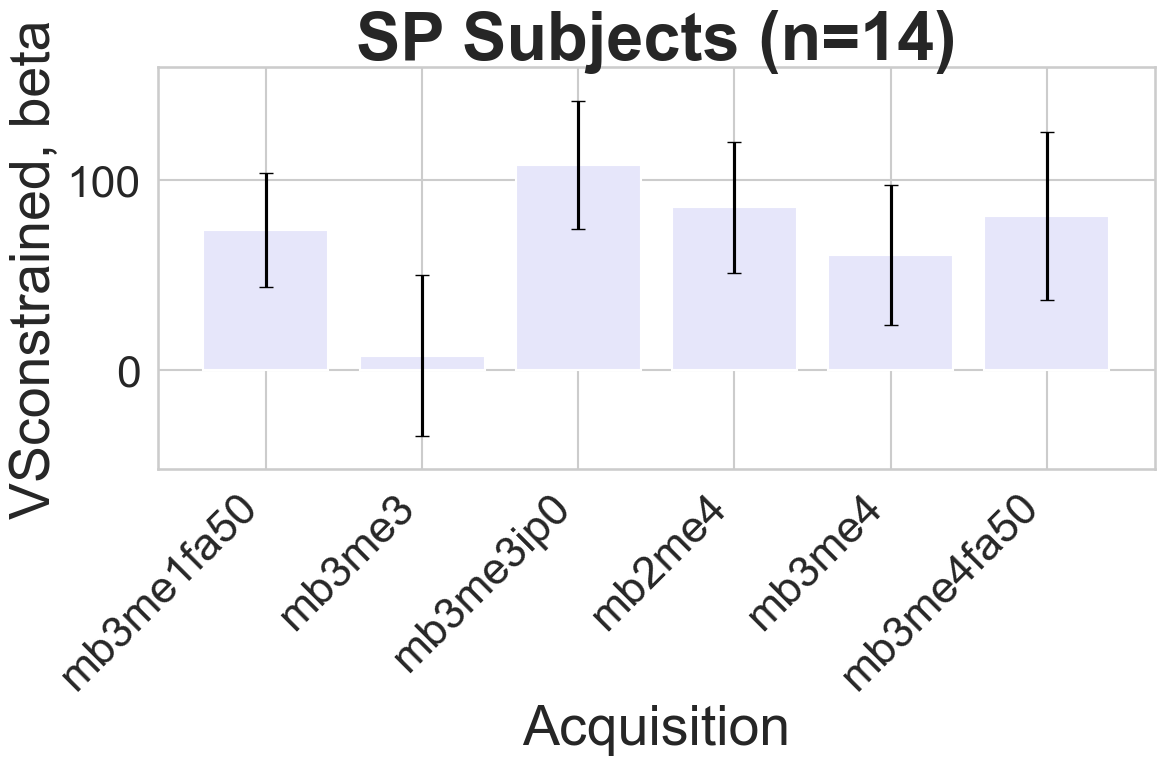

In [51]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from scipy.stats import chi2

# Activate pandas-R conversion
pandas2ri.activate()

# Import R packages
base = importr('base')
lme4 = importr('lme4')
emmeans = importr('emmeans')
ggplot2 = importr('ggplot2')

def extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value):
    """
    Extracts numerical data from text files matching specified parameters.
    
    Parameters:
    - base_dir: Path to the directory containing text files.
    - acq_params: List of acquisition parameters to include.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria for filenames.
    
    Returns:
    - data_by_subject: Dictionary with subjects as keys and acquisition data as values.
    """
    pattern = re.compile(
        r"ts_sub-(\d+[a-zA-Z]*)_acq_([^_]+)_type-(.+?)_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )

    data_by_subject = {}
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    matched_files = 0
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' not in sub_id:
                continue
            if (file_type.lower() == type_value.lower() and 
                img.lower() == img_value.lower() and 
                mask.lower() == mask_value.lower() and 
                denoise.lower() == denoise_value.lower() and 
                acq in acq_params):
                try:
                    with open(file_path, 'r') as f:
                        value = float(f.read().strip())
                    if sub_id not in data_by_subject:
                        data_by_subject[sub_id] = {acq_param: np.nan for acq_param in acq_params}
                    data_by_subject[sub_id][acq] = value
                    matched_files += 1
                except (ValueError, IOError) as e:
                    print(f"Error processing file {filename}: {e}")

    print(f"Total matched files: {matched_files}")
    return data_by_subject

def create_dataframe(data_by_subject, acq_params):
    """
    Converts extracted data into a structured DataFrame.

    Parameters:
    - data_by_subject: Dictionary with extracted numerical values.
    - acq_params: List of acquisition parameters.
    
    Returns:
    - df: DataFrame with subject IDs and extracted values.
    """
    df = pd.DataFrame.from_dict(data_by_subject, orient='index').reset_index()
    df.rename(columns={'index': 'subject'}, inplace=True)
    
    column_order = ['subject'] + acq_params
    df = df[column_order].sort_values('subject')
    
    return df

def prepare_plot_data(df, acq_params):
    """
    Computes means and standard errors for each acquisition parameter.

    Parameters:
    - df: DataFrame containing extracted values.
    - acq_params: List of acquisition parameters.

    Returns:
    - results: Dictionary with mean values, errors, and subject count.
    """
    means = {acq: df[acq].mean() for acq in acq_params}
    errors = {acq: df[acq].sem() for acq in acq_params}
    return {'means': means, 'errors': errors, 'count': len(df)}

def create_bar_plot(plot_data, acq_params, title, y_label):
    """
    Creates a formatted bar plot with error bars.

    Parameters:
    - plot_data: Dictionary with mean values, errors, and subject count.
    - acq_params: List of acquisition parameters.
    - title: Plot title.
    - y_label: Y-axis label.

    Returns:
    - fig: The created matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.set_context("talk")

    means = [plot_data['means'][acq] for acq in acq_params]
    errors = [plot_data['errors'][acq] for acq in acq_params]
    
    x_positions = np.arange(len(acq_params))
    ax.bar(x_positions, means, color='lavender', yerr=errors, capsize=5, width=0.8)

    ax.set_ylabel(y_label, fontsize=40)
    ax.set_title(title, fontsize=48, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(acq_params, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel('Acquisition', fontsize=40)
    ax.tick_params(axis='both', labelsize=32)

    y_min = min([v - e for v, e in zip(means, errors) if not np.isnan(v)])
    y_max = max([v + e for v, e in zip(means, errors) if not np.isnan(v)])
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)

    plt.tight_layout()
    return fig

def create_emm_line_plot(emm_df, mask_value, output_dir, type_value, img_value, denoise_value):
    """
    Create a line plot for estimated marginal means and save as PNG.

    Parameters:
    - emm_df: DataFrame with EMM data.
    - mask_value: Mask value for labeling.
    - output_dir: Directory to save the plot.
    - type_value, img_value, denoise_value: Parameters for filename.

    Returns:
    - fig: The created matplotlib figure.
    """
    plt.rcParams.update({'font.size': 56})
    fig, ax = plt.subplots(figsize=(12, 8))
    
    acq_params = sorted(emm_df['acq'].unique())
    custom_labels = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    lavender_color = '#800080'

    for acq in acq_params:
        acq_data = emm_df[emm_df['acq'] == acq]
        if not acq_data.empty:
            emmean = acq_data['emmean'].values[0]
            se = acq_data['SE'].values[0]
            x_pos = acq_params.index(acq)
            ax.errorbar([x_pos], [emmean], yerr=[se], fmt='o', color=lavender_color, capsize=8, capthick=4, elinewidth=3, markersize=15)

    x_positions = np.arange(len(acq_params))
    emmeans = [emm_df[emm_df['acq'] == acq]['emmean'].values[0] for acq in acq_params]
    ax.plot(x_positions, emmeans, color=lavender_color, linewidth=5, linestyle='-')

    ax.set_ylabel(f"{img_value} EMMs", fontsize=56)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(custom_labels, fontsize=32, rotation=45, ha='right')
    ax.set_xlabel("Acquisition", fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=32)

    y_values = emm_df['emmean'].values
    y_errors = emm_df['SE'].values
    if y_values.size > 0:
        y_upper = max(y_values + y_errors)
        y_lower = min(y_values - y_errors)
        padding = (y_upper - y_lower) * 0.1
        ax.set_ylim(y_lower - padding, y_upper + padding)
    else:
        ax.set_ylim(0, 1)

    plt.tight_layout()
    if output_dir:
        plot_file = os.path.join(output_dir, f"emm_plot_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"EMM plot saved as '{plot_file}'")
    plt.close()
    return fig

def generate_summary_table(df_long_clean, acq_params, lmm_result, tukey_acq, emm_df):
    """
    Generate APA-style summary table of ANOVA and related statistics.

    Parameters:
    - df_long_clean: DataFrame with cleaned data for analysis.
    - acq_params: List of acquisition parameters.
    - lmm_result: Linear mixed-effects model result.
    - tukey_acq: Tukey HSD pairwise comparison result.
    - emm_df: DataFrame with estimated marginal means.

    Returns:
    - summary_df: APA-style summary table as a DataFrame.
    """
    # ANOVA (LMM fixed effect) statistics
    anova_data = {
        'Statistic': ['F', 'df', 'p-value', 'Marginal R²'],
        'Value': []
    }
    if lmm_result is not None:
        # Compute F-test via likelihood ratio test
        try:
            # Fit reduced model without acq
            reduced_model = smf.mixedlm("beta ~ 1", df_long_clean, groups=df_long_clean["subject"])
            reduced_result = reduced_model.fit()
            # Likelihood ratio test
            lr_stat = 2 * (lmm_result.llf - reduced_result.llf)
            df_num = len(acq_params) - 1
            df_den = lmm_result.df_resid if hasattr(lmm_result, 'df_resid') else len(df_long_clean) - df_num - 1
            p_val = chi2.sf(lr_stat, df_num)
            # Approximate F-statistic: LR statistic / df_num
            f_stat = lr_stat / df_num if df_num > 0 else np.nan
        except Exception as e:
            print(f"Likelihood ratio test failed: {e}")
            f_stat = np.nan
            p_val = np.nan
            df_num = len(acq_params) - 1
            df_den = lmm_result.df_resid if hasattr(lmm_result, 'df_resid') else np.nan
        # Marginal R²: variance of fixed effects / (fixed + random + residual)
        if hasattr(lmm_result, 'scale') and hasattr(lmm_result, 'cov_re'):
            fixed_params = lmm_result.params[1:]  # Exclude intercept
            sigma_f = np.sum(fixed_params**2) if len(fixed_params) > 0 else 0
            sigma_r = lmm_result.cov_re.iloc[0, 0] if not lmm_result.cov_re.empty else 0
            sigma_e = lmm_result.scale
            total_var = sigma_f + sigma_r + sigma_e
            r2_marginal = sigma_f / total_var if total_var != 0 else np.nan
        else:
            r2_marginal = np.nan
        anova_data['Value'] = [f"{f_stat:.2f}", f"{df_num}, {df_den:.1f}", f"{p_val:.3f}", f"{r2_marginal:.2f}"]
    else:
        anova_data['Value'] = ["N/A", "N/A", "N/A", "N/A"]

    # Descriptive statistics and EMMs
    desc_data = {
        'Acquisition': [],
        'N': [],
        'Mean (SD)': [],
        'Range': [],
        'EMM (SE)': []
    }
    for i, acq in enumerate(acq_params):
        acq_data = df_long_clean[df_long_clean['acq'] == acq]
        n = len(acq_data)
        mean = acq_data['beta'].mean()
        sd = acq_data['beta'].std()
        min_val = acq_data['beta'].min()
        max_val = acq_data['beta'].max()
        # Match EMMs using integer index (1-based from R)
        emm_row = emm_df[emm_df['acq'] == str(i+1)] if emm_df is not None else pd.DataFrame()
        emm = emm_row['emmean'].iloc[0] if not emm_row.empty else np.nan
        se = emm_row['SE'].iloc[0] if not emm_row.empty else np.nan
        
        desc_data['Acquisition'].append(acq)
        desc_data['N'].append(n)
        desc_data['Mean (SD)'].append(f"{mean:.2f} ({sd:.2f})" if not np.isnan(mean) else "N/A")
        desc_data['Range'].append(f"[{min_val:.2f}, {max_val:.2f}]" if not np.isnan(min_val) else "N/A")
        desc_data['EMM (SE)'].append(f"{emm:.2f} ({se:.2f})" if not np.isnan(emm) else "N/A")

    # Pairwise comparisons (all pairs for completeness)
    pairwise_data = {
        'Comparison': [],
        'Mean Difference': [],
        '95% CI': [],
        'p-value': []
    }
    if tukey_acq is not None:
        tukey_df = pd.DataFrame(tukey_acq._results_table.data[1:], columns=tukey_acq._results_table.data[0])
        for _, row in tukey_df.iterrows():
            pairwise_data['Comparison'].append(f"{row['group1']} vs. {row['group2']}")
            pairwise_data['Mean Difference'].append(f"{row['meandiff']:.2f}")
            pairwise_data['95% CI'].append(f"[{row['lower']:.2f}, {row['upper']:.2f}]")
            pairwise_data['p-value'].append(f"{row['p-adj']:.3f}")

    # Combine into a single table with sections
    summary_df = pd.DataFrame()
    if anova_data['Value']:
        anova_df = pd.DataFrame(anova_data)
        anova_df.insert(0, 'Section', 'ANOVA')
        summary_df = pd.concat([summary_df, anova_df], ignore_index=True)
    
    desc_df = pd.DataFrame(desc_data)
    desc_df.insert(0, 'Section', 'Descriptive and EMM')
    summary_df = pd.concat([summary_df, desc_df], ignore_index=True)
    
    if pairwise_data['Comparison']:
        pairwise_df = pd.DataFrame(pairwise_data)
        pairwise_df.insert(0, 'Section', 'Pairwise Comparisons (Tukey HSD)')
        summary_df = pd.concat([summary_df, pairwise_df], ignore_index=True)

    return summary_df

def process_and_visualize(base_dir, acq_params, type_value, img_value, mask_value, denoise_value, output_dir="../derivatives/plots"):
    """
    Full pipeline to extract, process, visualize data, and perform statistical analysis.

    Parameters:
    - base_dir: Path to data files.
    - acq_params: List of acquisition parameters.
    - type_value, img_value, mask_value, denoise_value: Filtering criteria.
    - output_dir: Directory to save outputs.

    Returns:
    - df: Processed DataFrame.
    - fig: Bar plot figure.
    - emm_fig: EMM plot figure.
    - lmm_result: Linear mixed-effects model result.
    - summary_table: APA-style summary table.
    """
    print(f"Processing files with parameters: type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    data_by_subject = extract_file_data(base_dir, acq_params, type_value, img_value, mask_value, denoise_value)
    
    if not data_by_subject:
        print("No matching files found.")
        return pd.DataFrame(columns=['subject'] + acq_params), plt.figure(), plt.figure(), None, pd.DataFrame()
    
    df = create_dataframe(data_by_subject, acq_params)
    output_file = os.path.join(output_dir, f"multiecho_data_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv")
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")

    print(f"Found data for {len(df)} subjects")
    print("\nSample of the data:")
    print(df.head())
    print(f"Missing values per column:\n{df.isnull().sum()}")

    df_long = pd.melt(
        df, 
        id_vars=['subject'], 
        value_vars=acq_params,
        var_name='acq', 
        value_name=img_value
    )
    df_long['acq'] = pd.Categorical(df_long['acq'], categories=acq_params, ordered=True)

    print(f"\nRunning statistical analysis for {mask_value} ({img_value})...")
    df_long_clean = df_long.dropna(subset=[img_value])
    lmm_result, tukey_acq = None, None
    if len(df_long_clean) < 2:
        print(f"Insufficient data for LMM after removing NaNs: {len(df_long_clean)} observations")
    else:
        try:
            model = smf.mixedlm(f"{img_value} ~ acq", df_long_clean, groups=df_long_clean["subject"])
            lmm_result = model.fit()
            print(lmm_result.summary())
            
            print(f"\nPairwise comparisons for acquisition parameters:")
            tukey_acq = pairwise_tukeyhsd(endog=df_long_clean[img_value], groups=df_long_clean['acq'], alpha=0.05)
            print(tukey_acq)
        except Exception as e:
            print(f"LMM failed: {e}")
            print(f"Shape of df_long_clean: {df_long_clean.shape}")
            print(f"Missing values in df_long_clean:\n{df_long_clean.isnull().sum()}")

    print(f"\nRunning R-based EMM analysis for {mask_value} ({img_value})...")
    emm_df, emm_fig = None, None
    if len(df_long_clean) >= 2:
        try:
            rdf = pandas2ri.py2rpy(df_long_clean)
            ro.globalenv['rdf'] = rdf
            ro.globalenv['img_value'] = img_value
            ro.globalenv['acq_levels'] = ro.StrVector(acq_params)
            
            ro.r('''
            library(lme4)
            library(emmeans)
            
            rdf$subject <- as.factor(rdf$subject)
            rdf$acq <- factor(rdf$acq, levels = acq_levels)
            
            formula_str <- paste(img_value, "~ acq + (1 | subject)")
            model <- lmer(as.formula(formula_str), data = rdf)
            
            emm <- emmeans(model, ~ acq)
            emm_df <- as.data.frame(emm)
            ''')
            
            emm_df = pandas2ri.rpy2py(ro.globalenv['emm_df'])
            print(f"Debug: emm_df shape: {emm_df.shape}")
            print(f"Debug: emm_df columns: {emm_df.columns.tolist()}")
            print(f"Debug: emm_df head:\n{emm_df.head()}")
            
            emm_fig = create_emm_line_plot(emm_df, mask_value, output_dir, type_value, img_value, denoise_value)
            
        except Exception as e:
            print(f"R-based EMM analysis failed: {e}")

    print("\nGenerating APA-style summary table...")
    summary_table = generate_summary_table(df_long_clean, acq_params, lmm_result, tukey_acq, emm_df)
    table_file = os.path.join(output_dir, f"summary_stats_{type_value}_{img_value}_{mask_value}_{denoise_value}.csv")
    summary_table.to_csv(table_file, index=False)
    print(f"Summary table saved to {table_file}")
    print("\nAPA-style Summary Table:")
    print(summary_table.to_string(index=False))

    print("\nCreating bar plot...")
    plot_data = prepare_plot_data(df, acq_params)
    fig = create_bar_plot(plot_data, acq_params, f"SP Subjects (n={plot_data['count']})", f'{mask_value}, {img_value}')

    plot_file = os.path.join(output_dir, f"multiecho_plots_{type_value}_{img_value}_{mask_value}_{denoise_value}.png")
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Bar plot saved as '{plot_file}'")
    
    return df, fig, emm_fig, lmm_result, summary_table

if __name__ == "__main__":
    BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
    ACQ_PARAMS = ["mb3me1fa50", "mb3me3", "mb3me3ip0", "mb2me4", "mb3me4", "mb3me4fa50"]
    
    df, fig, emm_fig, lmm_result, summary_table = process_and_visualize(
        base_dir=BASE_DIR, 
        acq_params=ACQ_PARAMS, 
        type_value="act", 
        img_value="beta", 
        mask_value="VSconstrained", 
        denoise_value="base"
    )